In [9]:
# Dataset
#https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

#
!pip install kaggle
from google.colab import files

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:30<00:00, 72.7MB/s]
100% 2.29G/2.29G [00:30<00:00, 81.5MB/s]


In [10]:
import os, zipfile

zip_f = '/content/chest-xray-pneumonia.zip'

with zipfile.ZipFile(zip_f) as unzip:
    unzip.extractall('/content')

In [11]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

In [55]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# BATCH_SIZE 변수
BATCH_SIZE = 16
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]
# EPOCH 크기 변수
EPOCHS = 25
#데이터 ROOT 경로 변수
ROOT_PATH = '/content/chest_xray'

In [56]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/train/*/*'))
valid_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/val/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/test/*/*'))

print("Train Images :",len(train_filenames)) #5216
print("Valid Images :",len(valid_filenames)) #16
print("Test Images :",len(test_filenames)) #624

Train Images : 5216
Valid Images : 16
Test Images : 624


In [59]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/val/*/*')))

train_filenames, valid_filenames = train_test_split(filenames, test_size = 0.2)

print("Train Images :",len(train_filenames)) #4188
print("Valid Images :",len(valid_filenames)) #1048
print("Test Images :",len(test_filenames)) #624

Train Images : 4185
Valid Images : 1047
Test Images : 624


In [60]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1077
Pneumonia images count in training set: 3108


In [61]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(valid_filenames)

In [62]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [63]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/train/*"))])
print(CLASS_NAMES)

['NORMAL' 'PNEUMONIA']


In [64]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [65]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [66]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [67]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [68]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
print(TEST_IMAGE_COUNT)

624


In [69]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds
    
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

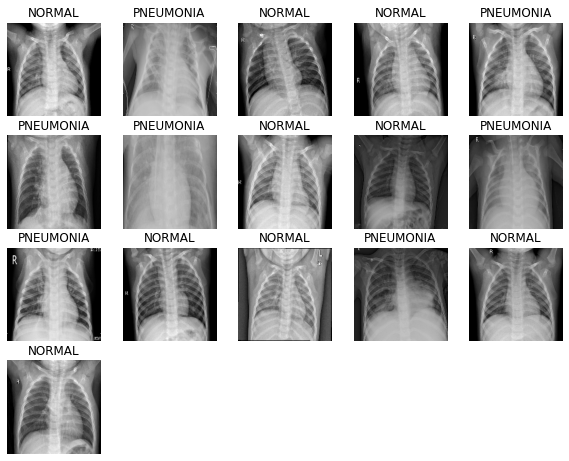

In [70]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
show_batch(image_batch.numpy(), label_batch.numpy())

In [71]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    return block

In [72]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

In [73]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [74]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [75]:
with tf.device('/GPU:0'):
    model = build_model()
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [76]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 37s 143ms/step - loss: 0.4041 - accuracy: 0.7998 - precision: 0.9457 - recall: 0.7749 - val_loss: 0.5939 - val_accuracy: 0.7394 - val_precision: 0.7394 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 37s 140ms/step - loss: 0.2474 - accuracy: 0.9021 - precision: 0.9693 - recall: 0.8964 - val_loss: 1.1150 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 37s 140ms/step - loss: 0.2037 - accuracy: 0.9246 - precision: 0.9781 - recall: 0.9191 - val_loss: 0.2368 - val_accuracy: 0.8885 - val_precision: 0.8717 - val_recall: 0.9961
Epoch 4/25
261/261 [==============================] - 37s 142ms/step - loss: 0.1765 - accuracy: 0.9346 - precision: 0.9787 - recall: 0.9323 - val_loss: 0.2570 - val_accuracy: 0.9163 - val_precision: 0.9942 - val_recall: 0.8922
Epoch 5/25
261/261 [==============================] - 37s 143ms/step - loss: 0.1789 - accura

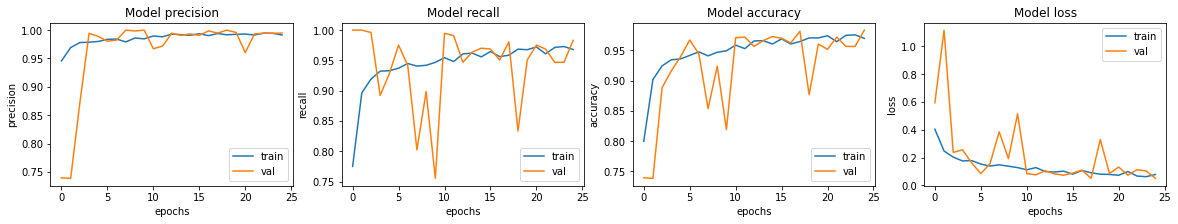

In [77]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [78]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 3s 85ms/step - loss: 1.0864 - accuracy: 0.8157 - precision: 0.7767 - recall: 0.9897
